# Deep Learning of Reaction Barrier Heights with ChemTorch
This two-part tutorial showcases how ORCA integrates into downstream deep learning workflows by serving as a data source training and evaluation.
1. First, we will show how to calculate the barrier height of a chemical reaction using ORCA with the ORCA Python inferface (OPI). 
2. Second, we use the ChemTorch framework to train and evaluate a graph neural network (GNN) on a curated subset of the popular [RGD1 dataset](https://www.nature.com/articles/s41597-023-02043-z) which contains precomputed barrier heights.

The term *barrier height* refers to the energy difference between reactant and transition state (TS).

## Part I: Obtaining Barrier Heights via ORCA/OPI
The first part of this tutorial consists of six steps:
1. Import Dependencies
2. Define Base Directory
3. Pick a Reaction
4. Setup and Run Calculations
5. Visualize the TS and IRC
6. Compute the Barrier Height

### Step 1: Import Dependencies
We start by importing the modules needed for:

- Interfacing with ORCA input/output
- Numerical calculations and data handling
- Plotting results

You might first need to install the additional required packages via
```bash
pip install py3Dmol rdkit matplotlib pandas
```

In [ ]:
from pathlib import Path
import shutil

# > OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.output.core import Output
from opi.input.structures.structure import Structure
from opi.input.arbitrary_string import ArbitraryStringPos
from opi.input.blocks import BlockNeb, BlockScf
from opi.input.simple_keywords import SimpleKeyword, BasisSet, Scf, Dft, Task, Neb, DispersionCorrection, Wft

# > for visualization of molecules
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol
import matplotlib.pyplot as plt

# > Pandas for data handling
import pandas as pd

### Step 2: Define Base Directory
We will create a `RUN` folder which will serve as the base directory for all ORCA calculations.

In [2]:
# > Calculation is performed in `RUN`
base_dir = Path("RUN")
base_dir.mkdir(exist_ok=True)

### Step 3: Pick a Reaction
For this example, we will remove a datapoint from the RGD1 dataset and calculate its barrier height from scatch.
We chose the tautomerization of acetone.

We will use the reactant and product geometries provided in the RGD1 dataset as a starting point for our calculations.
Please refer to the [original paper](https://www.nature.com/articles/s41597-023-02043-z) for a detailed explenation of how these structures were obtained.

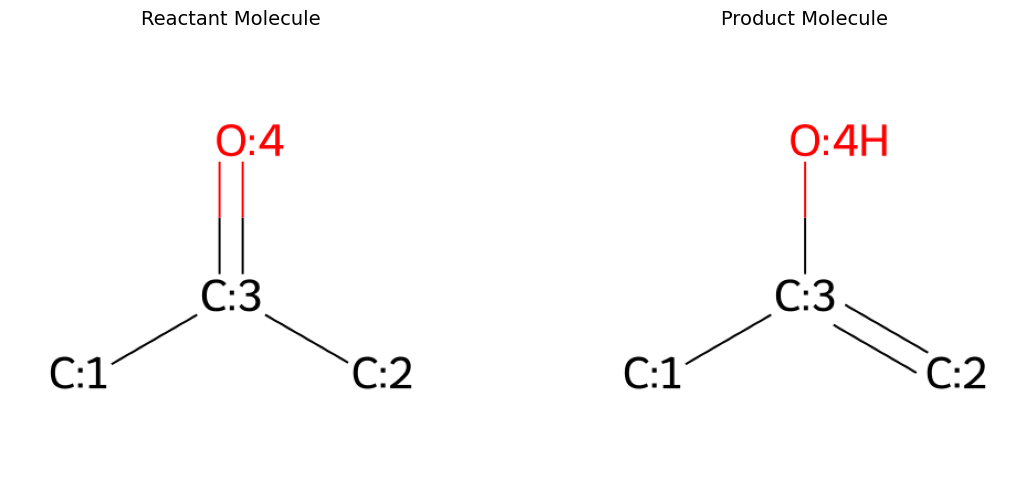

--- Reactant Structure ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

--- Product Structure ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
rxn_smiles = "[C:1]([C:3]([C:2]([H:8])([H:9])[H:10])=[O:4])([H:5])([H:6])[H:7]>>[C:1]([C:3](=[C:2]([H:8])[H:9])[O:4][H:10])([H:5])([H:6])[H:7]"
r_smiles, p_smiles = rxn_smiles.split(">>")
params = Chem.SmilesParserParams()
params.removeHs = False
r_mol = Chem.MolFromSmiles(r_smiles, params=params)
p_mol = Chem.MolFromSmiles(p_smiles, params=params)

r_xyz = """\
10

C      -1.460860000000000     -0.144010000000000     -0.053220000000000
C       1.050380000000000     -0.695950000000000      0.102060000000000
C      -0.033170000000000      0.331050000000000     -0.087970000000000
O       0.238150000000000      1.516350000000000     -0.275750000000000
H      -2.013860000000000      0.310400000000000     -0.879410000000000
H      -1.910310000000000      0.138980000000000      0.901700000000000
H      -1.508990000000000     -1.230020000000000     -0.166960000000000
H       1.412030000000000     -1.023800000000000     -0.875360000000000
H       0.669670000000000     -1.555760000000000      0.659270000000000
H       1.870170000000000     -0.255950000000000      0.676240000000000
"""

p_xyz = """\
10

C      -1.447246410000000     -0.119824230000000      0.000001190000000
C       0.825515320000000     -1.164474080000000      0.000015810000000
C       0.048387710000000     -0.090653610000000     -0.000104420000000
O       0.534209710000000      1.184537660000000      0.000015420000000
H      -1.822704290000000      0.402724090000000     -0.877993030000000
H      -1.822288580000000      0.399353360000000      0.880185840000000
H      -1.811964100000000     -1.141503600000000     -0.001665260000000
H       1.900576660000000     -1.090080000000000      0.000093490000000
H       0.410348040000000     -2.153410380000000      0.000030700000000
H       1.498440620000000      1.164676240000000      0.000145300000000
"""

def visualize_molecules_2d_side_by_side(mol1, mol2, title1="Molecule 1", title2="Molecule 2"):
    """Display 2D molecular structures side by side."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
    # Remove hydrogens for cleaner visualization
    mol1_no_h = Chem.RemoveHs(mol1)
    mol2_no_h = Chem.RemoveHs(mol2)
    # Create drawing options
    opts = Draw.rdMolDraw2D.MolDrawOptions()
    opts.addAtomIndices = False  # Hide atom numbering
    opts.addStereoAnnotation = False  # Hide stereo annotations
    
    # Generate 2D images with custom options
    img1 = Draw.MolToImage(mol1_no_h, size=(400, 400), options=opts)
    img2 = Draw.MolToImage(mol2_no_h, size=(400, 400), options=opts)
    
    # Display images
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=14, pad=10)
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=14, pad=10)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_molecule(xyz_string: str, name: str=None):
    """
    Visualize a molecule from its XYZ string using py3Dmol.
    
    Args:
        xyz_string: XYZ format string of the molecule
        name: Name for the molecule (used as visualization title)
    """
    if name:
        print(f"--- {name.title()} Structure ---")
    view = py3Dmol.view(width=400, height=400)
    view.addModel(xyz_string, 'xyz')
    view.setStyle({}, {'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
    view.setBackgroundColor('white')
    view.zoomTo()
    view.show()


def save_molecule(xyz_string: str, name: str, working_dir: Path):
    """
    Save the XYZ string to a file in the specified working directory.
    
    Args:
        xyz_string: XYZ format string of the molecule
        name: Name for the molecule (used for filename)
        working_dir: Directory to save the XYZ file
    """
    xyz_file = working_dir / f"{name}.xyz"
    with open(xyz_file, "w") as f:
        f.write(xyz_string)

visualize_molecules_2d_side_by_side(r_mol, p_mol, "Reactant Molecule", "Product Molecule")
visualize_molecule(r_xyz, "reactant")
visualize_molecule(p_xyz, "product")
save_molecule(r_xyz, "reactant", base_dir)
save_molecule(p_xyz, "product", base_dir)

### Step 4: Setup and Run Calculations
We will run three kinds of calculations: 
1. First, we optimize the geometries of our initial reactant and product structures.
2. Then we start a nudge elastic band (NEB) TS search starting from the optimized reactant and product geometries.
3. Finally, we calculate the intrinsic reaction coordinate (IRC) from the found TS. This is not strictly necessary to calculate the barrier height of the reaction but it allows for a nice visualization of the reaction.

For all calculations, we additionally perform vibrational frequency calculations to obtain thermochemistry information including the single point energies needed to determine the barrier height of the reaction.

RGD1 was obtained on a B3LYP-D3/TZVP level of theory and thight SCF. If you would like to reproduce these results, use
```python
SIMPLE_KEYWORDS = [
    Dft.B3LYP,                  # > B3LYP-D3 method
    DispersionCorrection.D3,    # > D3
    BasisSet.TZVP,              # > TZVP basis set
    Task.FREQ,                  # > Vibration frequency calculation to get thermochemistry
    Scf.TIGHTSCF,               # > tight SCF
]
```
(the commented-out part below). The NEB search will take a few hours then. If you would like to make a dummy calculation with a much lower level of theory, you can use HF/STO-3G as detailed below. The NEB search will then complete in a few minutes.

In [ ]:
# > Define simple keywords for the ORCA calculation, here with a lower level of theory
SIMPLE_KEYWORDS = [
    Wft.HF,                     # > Hartree-Fock method
    BasisSet.STO_3G,            # > STO3G basis set
    Task.FREQ,                  # > Vibration frequency calculation to get thermochemistry
]

'''# > Define simple keywords for the ORCA calculation, consistent with RGD1. Uncomment this part if you like.
SIMPLE_KEYWORDS = [
    Dft.B3LYP,                  # > B3LYP method
    DispersionCorrection.D3,    # > D3 correction
    BasisSet.TZVP,              # > TZVP basis set
    Task.FREQ,                  # > Vibration frequency calculation to get thermochemistry
    Scf.TIGHTSCF,               # > tight SCF
]
'''

# > Set number of cores for the calculation
NCORES = 2

In [ ]:
# > Define setup functions for all three calculator types
def setup_opt_calc(basename : str, xyz_file: str, base_dir: Path, ncores: int, sk_list: list[SimpleKeyword]) -> Calculator:
    # > Setup subdirectory for geometry optimization calculations
    working_dir = base_dir / "geometry_optimization"
    working_dir.mkdir(parents=True, exist_ok=True)  # Ensure the subdirectory exists

    # > Specify geometry optimization as task
    sk_list = sk_list.copy()
    sk_list.append(Task.OPT)

    # > Set up a Calculator object
    calc = Calculator(basename=basename, working_dir=working_dir)
    # > Assign structure to calculator
    calc.structure = Structure.from_xyz(base_dir / xyz_file)
    # > Add simple keywords to calculator
    calc.input.add_simple_keywords(*sk_list)
    # > Set the number of CPUs for the calculation
    calc.input.ncores = ncores

    return calc

def setup_neb_calc(basename: str, r_xyz_file: str, p_xyz_file: str, base_dir: Path, ncores: int, sk_list: list[SimpleKeyword]) -> Calculator:
    working_dir = base_dir / "nudged_elastic_band"
    working_dir.mkdir(parents=True, exist_ok=True)
    # > Copy the product XYZ file to the calculation directory so ORCA can find it
    p_xyz_path = base_dir / p_xyz_file
    dest_path = working_dir / p_xyz_path.name
    shutil.copy2(p_xyz_path, dest_path)

    sk_list = sk_list.copy()
    sk_list.append(Neb.NEB_TS)

    calc = Calculator(basename=basename, working_dir=working_dir)
    calc.structure = Structure.from_xyz(base_dir / r_xyz_file)
    # > Define input block for product structure
    calc.input.add_blocks(BlockNeb(neb_end_xyzfile=p_xyz_path.name))
    # > Add options to the calculator
    calc.input.add_simple_keywords(*sk_list)
    calc.input.ncores = ncores

    return calc

def setup_irc_calc(basename: str, xyz_file: str, base_dir: Path, ncores: int, sk_list: list[SimpleKeyword]) -> Calculator:
    working_dir = base_dir / "intrinsic_reaction_coordinate"
    working_dir.mkdir(parents=True, exist_ok=True)  # Ensure the subdirectory exists

    sk_list = sk_list.copy()
    sk_list.append(Neb.IRC)

    calc = Calculator(basename=basename, working_dir=working_dir)
    calc.structure = Structure.from_xyz(base_dir / xyz_file)
    calc.input.add_blocks(BlockScf(maxiter=200))
    calc.input.add_simple_keywords(*sk_list)
    calc.input.ncores = ncores

    return calc

In [7]:
def run_calc(calc: Calculator) -> Output:
    # > Write the ORCA input file
    calc.write_input()
    # > Run the ORCA calculation
    print("Running ORCA calculation ...", end="")
    calc.run()
    print("   Done")
    # > Get the output object
    output = calc.get_output()
    
    return output

def check_and_parse_output(output: Output):
    # > Check for proper termination of ORCA
    status = output.terminated_normally()
    if not status:
        # > ORCA did not terminate normally
        raise RuntimeError(f"ORCA did not terminate normally. Please check {output.basename}.out file")
    else:
        # > ORCA did terminate normally so we can parse the output
        output.parse()
    # > Now check for convergence of the SCF
    if output.results_properties.geometries[-1].single_point_data.converged:
        print(f"{output.basename}: SCF CONVERGED")
    else:
        raise RuntimeError("SCF DID NOT CONVERGE")


First, run the geometry optimization:

In [ ]:
r_opt_calc = setup_opt_calc("reactant", "reactant.xyz", base_dir, ncores=NCORES, sk_list=SIMPLE_KEYWORDS)
r_opt_out = run_calc(r_opt_calc)
check_and_parse_output(r_opt_out)

Running ORCA calculation ...   Done
reactant: SCF CONVERGED


In [ ]:
p_opt_calc = setup_opt_calc("product", "product.xyz", base_dir, ncores=NCORES, sk_list=SIMPLE_KEYWORDS)
p_opt_out = run_calc(p_opt_calc)
check_and_parse_output(p_opt_out)

Running ORCA calculation ...   Done
product: SCF CONVERGED


Then run nudege elastic band search on the optimized reactant and product geometries (this will take a few minutes with HF/STO-3G and several hours for B3LYP-D3/TZVP):

In [ ]:
neb_ts_calc = setup_neb_calc("ts", "geometry_optimization/reactant.xyz", "geometry_optimization/product.xyz", base_dir, ncores=NCORES, sk_list=SIMPLE_KEYWORDS)
neb_ts_out = run_calc(neb_ts_calc)
check_and_parse_output(neb_ts_out)

Running ORCA calculation ...   Done
ts: SCF CONVERGED


Finally, run the IRC calculation for visualization purposes:

In [ ]:
irc_calc = setup_irc_calc("irc", "nudged_elastic_band/ts.xyz", base_dir, ncores=NCORES, sk_list=SIMPLE_KEYWORDS)
irc_out = run_calc(irc_calc)
check_and_parse_output(irc_out)

Running ORCA calculation ...   Done
irc: SCF CONVERGED


### Step 5: Visualize TS and IRC

In [5]:
ts_xyz_file = base_dir / "nudged_elastic_band" / "ts.xyz"
with open(ts_xyz_file, "r") as f:
    ts_xyz = f.read()
visualize_molecule(ts_xyz, "transition state")

--- Transition State Structure ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
def animate_trajectory(trajectory_file: Path):
    """
    Animate a trajectory from a multi-frame XYZ file using py3Dmol.
    
    Args:
        trajectory_file: Path to the XYZ trajectory file
        name: Name for the animation
    """
    with open(trajectory_file, "r") as f:
        trajectory_content = f.read()
    view = py3Dmol.view(width=600, height=400)
    view.addModelsAsFrames(trajectory_content, 'xyz')
    view.setStyle({}, {'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
    view.setBackgroundColor('white')
    view.animate({'loop': 'forward'})
    view.zoomTo()
    view.show()

trj_file = base_dir / "intrinsic_reaction_coordinate" / "irc_IRC_Full_trj.xyz"
animate_trajectory(trj_file)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Step 6: Calculate the Barrier Height
We calculate the barrier height as the energy difference between reactant and transition state.
We will use electron energy since it will also be used for training in Part II.

The energies can be found in the thermochemistry information of the ORCA output which was obtained via the addtional vibrational frequency calculations.

In [16]:
E_r = r_opt_out.results_properties.geometries[-1].thermochemistry_energies[0].elenergy
E_p = p_opt_out.results_properties.geometries[-1].thermochemistry_energies[0].elenergy
E_ts = neb_ts_out.results_properties.geometries[-1].thermochemistry_energies[0].elenergy
delta_E_act = E_ts - E_r
delta_E_rp = E_p - E_r

# > Convert to kcal/mol
HARTREE_TO_KCAL_MOL = 627.509
delta_E_act_kcal = delta_E_act * HARTREE_TO_KCAL_MOL
delta_E_rp_kcal = delta_E_rp * HARTREE_TO_KCAL_MOL

print(f"""
ELECTRON ENERGY (E):
Activation:     {delta_E_act_kcal:.6f} kcal/mol, {delta_E_act:.6f} Eh
Reaction:       {delta_E_rp_kcal:.6f} kcal/mol, {delta_E_rp:.6f} Eh
""")


ELECTRON ENERGY (E):
Activation:     106.655528 kcal/mol, 0.169967 Eh
Reaction:       19.588445 kcal/mol, 0.031216 Eh



Now, the HF/STO-3G values are of course quite off. With B3LYP-D3/TZVP, we obtain `67.935952` kcal/mol. The RGD1 dataset reports an barrier height of `68.35608500000312` kcal/mol (electron energy) for this reaction.
Given that the RGD1 dataset was constructed using a slightly different approach a small deviation of approximately 0.3 kcal/mol is tolerable.

Now, we will save the reaction SMILES to a CSV file for later use. We will also overwrite `delta_E_act_kcal` to the value at the correct level of theory, since we will compare machine learning model predictions to this value later.

In [17]:
#Overwrite target to correct level of theory (this is unnecessary if you used to correct level of theory above)
delta_E_act_kcal = 67.935952

In [18]:
# > Save the smiles of the reaction to a CSV file 
import pandas as pd
data = {
    "smiles": [rxn_smiles],
    "ea": [delta_E_act_kcal]
}

df = pd.DataFrame(data)
df.to_csv("QM_data.csv", index=False)
df

,smiles,ea
0,[C:1]([C:3]([C:2]([H:8])([H:9])[H:10])=[O:4])(...,67.935952


To build a full machine learning dataset we would repeat this for many more reactions.
Of course, dataset construction also involves other considerations like chemical space coverage and dataset curration.
However, these topics are beyond the scope of this tutorial.

## Part II: Training a GNN to Predict Activation Free Energies via ChemTorch
The second part consists of four steps:
1. Download a small subset of the RGD1 dataset.
2. Install ChemTorch
3. Train and Evaluate GNN via ChemTorch CLI.
4. Use Model to Predict Activation Free Energy

The remainder of this tutorial will run on the command line, please navigate to the folder where you are currently running this tutorial (and thus `QM_data.csv` and `QM_data_precomputed.csv` are already located), and run the commands below on the command line in this folder).

### Step 1: Download the RGD1 Dataset (a subset)

Since for a tutorial you cannot run hundreds of calculation, we will now donwload a subset of RGD1 to use in our machine learning model instead of the `QM_data.csv` above which we just made. It is exactly the same information, just about 15k reactions instead of the only 1 from above.

```bash
wget https://raw.githubusercontent.com/heid-lab/reaction_database/main/data/rgd1/barriers/filtered.csv -O QM_data_precomputed.csv
```

You can inspect the `QM_data_precomputed.csv` to see it is just more reactions than above, but the exact same format.

### Step 2: Install ChemTorch
To begin our ML workflow, clone and install ChemTorch following the [official installation instructions](https://github.com/heid-lab/chemtorch) or the command below (for GPU installation, please refer to the installation instructions). We recommend to set up a separate environment than for the first part of this tutorial. 

```bash
git clone -b tutorial/opi_orca https://github.com/heid-lab/chemtorch.git && \
cd chemtorch && \
conda deactivate && \
conda create -n chemtorch python=3.10 && \
conda activate chemtorch && \
pip install rdkit numpy==1.26.4 scikit-learn pandas && \
pip install torch && \
pip install hydra-core && \
pip install torch_geometric && \
pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.0+cpu.html && \
pip install wandb && \
pip install ipykernel && \
pip install -e .
```

### Step 3: Train and Evaluate GNN via ChemTorch CLI
In this section, we train a Directed Message Passing Neural Network (DMPNN)—a widely used GNN architecture for molecular property prediction.
ChemTorch provides ready-to-use configuration files, including a complete pipeline for training DMPNNs on the [RGD1 dataset](https://www.nature.com/articles/s41597-023-02043-z).
> 🔗 For more models, representations, and datasets, visit the [ChemTorch GitHub repository](https://github.com/heid-lab/chemtorch).

> 📚 To define your own GNNs or molecular representations, consult the [ChemTorch documentation](https://github.com/heid-lab/chemtorch).

To use our own custom dataset `QM_data_precomputed.csv`, we can either set up our own configuration file, or use an existing one and overwrite the path to the dataset.

To use an existing one, run the following command from the `chemtorch` project root:

```bash
python chemtorch_cli.py +experiment=graph data_pipeline=rgd1 data_pipeline.data_source.data_path="../QM_data_precomputed.csv"
```

This tells ChemTorch to use the default graph learning configuration with the RGD1 data pipeline but use our own custom dataset specified via `data_path`.
Under the hood, this setup will convert each reaction SMILES to a condensed graph of reaction (CGR), train a DMPNN, track metrics of interest and save the best performing model parameters for later.
to the CLI as well as [Weights & Biases](https://wandb.ai/site/models/) which is a graphical user interface that can be accessed through the browser.

If you would like to make your own configuration file instead, an example is already included in your ChemTorch installation, and can be found in `conf/experiment/opi_tutorial/training.yaml`, so no need to create or change a file. Note that the important lines are setting the `data_pipeline` to `rgd1`, and `data_pipeline/data_source/data_path` to `"../QM_data_precomputed.csv"`, just as above. To launch the training process with the config file, run 
```bash 
python chemtorch_cli.py +experiment=opi_tutorial/training
```
from the `chemtorch` project root (do not redo this if you already ran ChemTorch above).

Either way, the ChemTorch CLI will output
1. a link to a detailed real-time view of the ongoing run on [Weights & Biases](https://wandb.ai/site/models/) which can be accessed via the browser (can be disabled by setting `log=false`), 
2. a progress bar, and 
3. a summary of the run including the final training, validation and test metrics.

```txt
 ██████╗██╗  ██╗███████╗███╗   ███╗████████╗ ██████╗ ██████╗  ██████╗██╗  ██╗
██╔════╝██║  ██║██╔════╝████╗ ████║╚══██╔══╝██╔═══██╗██╔══██╗██╔════╝██║  ██║
██║     ███████║█████╗  ██╔████╔██║   ██║   ██║   ██║██████╔╝██║     ███████║
██║     ██╔══██║██╔══╝  ██║╚██╔╝██║   ██║   ██║   ██║██╔══██╗██║     ██╔══██║
╚██████╗██║  ██║███████╗██║ ╚═╝ ██║   ██║   ╚██████╔╝██║  ██║╚██████╗██║  ██║
 ╚═════╝╚═╝  ╚═╝╚══════╝╚═╝     ╚═╝   ╚═╝    ╚═════╝ ╚═╝  ╚═╝ ╚═════╝╚═╝  ╚═╝

...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Epoch 74: 100%|██████████| 271/271 [00:03<00:00, 77.02it/s, v_num=rnz2, train_loss=1.480, val_loss_step=28.70, val_loss_epoch=12.30]
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 125.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch         11.29045295715332
        test_mae             4.308720588684082
        test_rmse            6.559021949768066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
wandb: uploading history steps 1595-1697, summary, console lines 1-1
wandb:
wandb:
wandb: Run history:
wandb:                 epoch ▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇█████
wandb:       test_loss_epoch ▁
wandb:        test_loss_step ▃█▃▄▃▄▃▆█▄▅▅▂▂▄▁
wandb:              test_mae ▁
wandb:  test_precompute_time ▁
wandb:             test_rmse ▁
wandb:      total_parameters ▁
wandb:            train_loss █▇▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▂▁▁▂▂▁▁▂
wandb: train_precompute_time ▁
wandb:            train_rmse █▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   trainer/global_step ▁▁▁▁▁▂▂▁▁▁▁▁▃▃▃▁▁▄▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▁▁█▁█▁▁
wandb:        val_loss_epoch █▅▄▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:         val_loss_step █▃▃▃▂▃▂▂▃▃▂▂▁▂▄▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▂▂▁▂▄▂▁▂▂▁
wandb:              val_rmse █▅▄▃▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
wandb:
wandb: Run summary:
wandb:                 epoch 75
wandb:       test_loss_epoch 11.29045
wandb:        test_loss_step 0.16354
wandb:              test_mae 4.30872
wandb:  test_precompute_time 2.78497
wandb:             test_rmse 6.55902
wandb:      total_parameters 305921
wandb:            train_loss 2.91344
wandb: train_precompute_time 50.13324
wandb:            train_rmse 4.08851
wandb:   trainer/global_step 20325
wandb:        val_loss_epoch 12.25211
wandb:         val_loss_step 28.69574
wandb:              val_rmse 6.85208
```

### Step 4: Predict Barrier Height for Unseen Reaction
Now, we can load our trained model and use it to predict the barrier height of new reactions that aren't in the training dataset, for example the datapoint computed in Part I.

We will use the config file in `conf/experiment/opi_tutorial/inference.yaml` (shipped with the ChemTorch repo, no need to make this file again).

Overwrite the checkpoint path in the command directly, or replace the `ckpt_path: "lightning_logs/rgd1/dmpnn/seed_0_YYYY-MM-DD_HH-MM-SS/checkpoints/epoch=XX-step=XXXXX.ckpt"` with your actual log name from the training run in `conf/experiment/opi_tutorial/inference.yaml`. We will overide it so you don't need to open the file:
```bash
python chemtorch_cli.py +experiment=opi_tutorial/inference ckpt_path="lightning_logs/rgd1/dmpnn/seed_0_2025-08-13_10-28-40/checkpoints/epoch\=58-step\=15989.ckpt prediction_save_path="../predictions.csv"
```
When overriding `ckpt_path` in the CLI make sure to wrap the path in double quotes and escape `=` characters by plycing `\` in front of them like we did.
Remember that the file path will be different for you!
Assuming that the `chemtorch` folder is located in the same folder as this notebook, then the predictions will be saved as `predictions.csv` in the the same folder.

```txt

 ██████╗██╗  ██╗███████╗███╗   ███╗████████╗ ██████╗ ██████╗  ██████╗██╗  ██╗
██╔════╝██║  ██║██╔════╝████╗ ████║╚══██╔══╝██╔═══██╗██╔══██╗██╔════╝██║  ██║
██║     ███████║█████╗  ██╔████╔██║   ██║   ██║   ██║██████╔╝██║     ███████║
██║     ██╔══██║██╔══╝  ██║╚██╔╝██║   ██║   ██║   ██║██╔══██╗██║     ██╔══██║
╚██████╗██║  ██║███████╗██║ ╚═╝ ██║   ██║   ╚██████╔╝██║  ██║╚██████╗██║  ██║
 ╚═════╝╚═╝  ╚═╝╚══════╝╚═╝     ╚═╝   ╚═╝    ╚═════╝ ╚═╝  ╚═╝ ╚═════╝╚═╝  ╚═╝

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]
Predictions saved to: /your/path/to/opi/docs/contents/notebooks/predictions.csv
```

Now we can load the prediction and compare it to the barrier height obtained from the ORCA calculation and the value reported by RGD1. Note that model training can differ between architectures (e.g. GPU vs CPU), so you might not get exactly the same numbers.

In [ ]:
# > Load predictions from the CSF file
df = pd.read_csv("predictions.csv")
delta_E_act_kcal_predicted = df["prediction"].values[0]

In [ ]:
rgd1_delta_E_act_kcal = 68.35608500000312  # > RGD1 value for the barrier height in kcal/mol
# > Calculate absolute errors
error_to_orca_calc = delta_E_act_kcal_predicted - delta_E_act_kcal
error_to_rgd1 = delta_E_act_kcal_predicted - rgd1_delta_E_act_kcal

# > Calculate relative errors
relative_error_to_orca_calc = error_to_orca_calc / delta_E_act_kcal
relative_error_to_rgd1 = error_to_rgd1 / rgd1_delta_E_act_kcal


print(f"""
PREDICTED BARRIER HEIGHT:     {delta_E_act_kcal_predicted:.6f} kcal/mol
ERROR TO ORCA CALCULATION:        {error_to_orca_calc:.6f} kcal/mol, {relative_error_to_orca_calc:.2%}
ERROR TO REPORTED VALUE IN RGD1:  {error_to_rgd1:.6f} kcal/mol, {relative_error_to_rgd1:.2%}
""")


PREDICTED ACTIVATION ENERGY:     69.493736 kcal/mol
ERROR TO ORCA CALCULATION:        1.557785 kcal/mol, 2.29%
ERROR TO REPORTED VALUE IN RGD1:  1.137651 kcal/mol, 1.66%

